In [36]:
import pandas as pd
import numpy as np
import sklearn
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.impute import SimpleImputer
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import RareLabelEncoder, MeanEncoder, CountFrequencyEncoder, OrdinalEncoder
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output='pandas')

In [4]:
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv('C:/Users/Akanksha/Flight_Price_Prediction/data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          6694 non-null   object 
 1   Date_of_Journey  6694 non-null   object 
 2   Source           6694 non-null   object 
 3   Destination      6694 non-null   object 
 4   Dep_Time         6694 non-null   object 
 5   Arrival_Time     6694 non-null   object 
 6   Duration         6694 non-null   float64
 7   Total_Stops      6694 non-null   int64  
 8   Additional_Info  6694 non-null   object 
 9   Price            6694 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.1+ KB


In [6]:
X_train = train.drop('Price', axis=1)
y_train = train['Price']

##### Airline : Imputation -> Grouping -> One-hot Encoding

In [7]:
air_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('grouper', RareLabelEncoder(tol=0.10, replace_with = 'Others', n_categories=2)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

air_transformer.fit_transform(X_train.loc[:,['Airline']])

,Airline_Air India,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple Carriers,Airline_Others
0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6689,0.0,1.0,0.0,0.0,0.0
6690,0.0,1.0,0.0,0.0,0.0
6691,0.0,0.0,0.0,0.0,1.0
6692,0.0,0.0,0.0,0.0,1.0


Date_of_Journey : 

In [8]:
X_train.Date_of_Journey

0       2019-05-24
1       2019-04-12
2       2019-05-03
3       2019-06-27
4       2019-05-21
           ...    
6689    2019-05-18
6690    2019-03-21
6691    2019-05-06
6692    2019-05-27
6693    2019-06-24
Name: Date_of_Journey, Length: 6694, dtype: object

In [9]:
features_to_extract = ['month', 'week', 'day_of_week', 'day_of_year']

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=features_to_extract, yearfirst=True, format='mixed')),
    ('scaling', MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,['Date_of_Journey']])

,Date_of_Journey_month,Date_of_Journey_week,Date_of_Journey_day_of_week,Date_of_Journey_day_of_year
0,0.666667,0.705882,0.666667,0.711864
1,0.333333,0.352941,0.666667,0.355932
2,0.666667,0.529412,0.666667,0.533898
3,1.000000,1.000000,0.500000,1.000000
4,0.666667,0.705882,0.166667,0.686441
...,...,...,...,...
6689,0.666667,0.647059,0.833333,0.661017
6690,0.000000,0.176471,0.500000,0.169492
6691,0.666667,0.588235,0.000000,0.559322
6692,0.666667,0.764706,0.000000,0.737288


Source and Destination

In [10]:
X_train.Source.unique(), X_train.Destination.unique()

(array(['Banglore', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai'], dtype=object),
 array(['Delhi', 'Kolkata', 'Cochin', 'Banglore', 'Hyderabad', 'New Delhi'],
       dtype=object))

In [11]:
X_train.Source.value_counts(), X_train.Destination.value_counts()

(Source
 Delhi       2779
 Kolkata     1839
 Banglore    1371
 Mumbai       448
 Chennai      257
 Name: count, dtype: int64,
 Destination
 Cochin       2779
 Banglore     1839
 Delhi         798
 New Delhi     573
 Hyderabad     448
 Kolkata       257
 Name: count, dtype: int64)

In [12]:
location_transformer = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.10, replace_with = 'Others', n_categories=2)),
    ('mean_encoder', MeanEncoder()),
    ('power-transformer', PowerTransformer())
])

location_transformer.fit_transform(X_train.loc[:,['Source','Destination']], y_train)

,Source,Destination
0,-0.920590,-1.837680
1,-0.920590,-1.837680
2,-1.857672,-0.838307
3,1.045647,1.044031
4,-0.181656,-0.197682
...,...,...
6689,-0.920590,-1.837680
6690,-0.920590,-0.838307
6691,1.045647,1.044031
6692,-1.857672,-0.838307


In [13]:
np.union1d(
    X_train.Source.unique(), 
    X_train.Destination.unique(
    )
    )

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [14]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi', 'Mumbai', 'Kolkata', 'New Delhi']
    
    return (
        X
        .assign(**{
            f'{col}_is_north': X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        }
        )
        .drop(columns=['Source', 'Destination'], axis=1)
    )
    
FunctionTransformer(func=is_north).fit_transform(X_train.loc[:,['Source','Destination']])

,Source_is_north,Destination_is_north
0,0,1
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
6689,0,1
6690,0,1
6691,1,0
6692,0,1


In [15]:
loc = FeatureUnion(transformer_list=[
    ('part1', location_transformer),
    ('part2', FunctionTransformer(func=is_north)),
]
)

loc.fit_transform(X_train.loc[:,['Source','Destination']], y_train)

,Source,Destination,Source_is_north,Destination_is_north
0,-0.920590,-1.837680,0,1
1,-0.920590,-1.837680,0,1
2,-1.857672,-0.838307,0,1
3,1.045647,1.044031,1,0
4,-0.181656,-0.197682,1,0
...,...,...,...,...
6689,-0.920590,-1.837680,0,1
6690,-0.920590,-0.838307,0,1
6691,1.045647,1.044031,1,0
6692,-1.857672,-0.838307,0,1


In [16]:
time_transformer_1 = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=['hour', 'minute'])),
    ('scaler', MinMaxScaler())
])

time_transformer_1.fit_transform(X_train.loc[:,['Dep_Time', 'Arrival_Time']])

,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,0.913043,0.181818,0.000000,0.090909
1,0.782609,1.000000,0.913043,0.909091
2,0.478261,0.636364,0.608696,0.000000
3,0.304348,0.000000,0.826087,0.000000
4,0.260870,0.545455,0.695652,0.363636
...,...,...,...,...
6689,0.347826,0.545455,0.478261,0.363636
6690,0.826087,0.636364,0.000000,0.636364
6691,0.304348,0.454545,0.565217,0.636364
6692,0.739130,0.818182,0.869565,0.090909


In [17]:
def part_of_day(X, morning=4, afternoon=12, evening=16, night=20):
    columns = X.columns.to_list()
    X_copy = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns}
    )
    return (
        X_copy
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_copy.loc[:, col].between(morning, afternoon, inclusive='left'),
                 X_copy.loc[:, col].between(afternoon, evening, inclusive='left'),
                 X_copy.loc[:, col].between(evening, night, inclusive='left')],
                ["morning", 'afternoon', 'evening'],
                default='night'
            )
            for col in columns
        })
        .drop(columns=['Dep_Time', 'Arrival_Time'], axis=1)
    )
        
FunctionTransformer(func=part_of_day).fit_transform(X_train.loc[:,['Dep_Time', 'Arrival_Time']])

,Dep_Time_part_of_day,Arrival_Time_part_of_day
0,night,night
1,evening,night
2,morning,afternoon
3,morning,evening
4,morning,evening
...,...,...
6689,morning,morning
6690,evening,night
6691,morning,afternoon
6692,evening,night


In [18]:
time_transformer_2 = Pipeline(steps=[
    ('pod', FunctionTransformer(func=part_of_day)),
    ('encoder', CountFrequencyEncoder()),
    ('scaler', MinMaxScaler())
])

time_transformer_1.fit_transform(X_train.loc[:,['Dep_Time', 'Arrival_Time']])

,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,0.913043,0.181818,0.000000,0.090909
1,0.782609,1.000000,0.913043,0.909091
2,0.478261,0.636364,0.608696,0.000000
3,0.304348,0.000000,0.826087,0.000000
4,0.260870,0.545455,0.695652,0.363636
...,...,...,...,...
6689,0.347826,0.545455,0.478261,0.363636
6690,0.826087,0.636364,0.000000,0.636364
6691,0.304348,0.454545,0.565217,0.636364
6692,0.739130,0.818182,0.869565,0.090909


In [19]:
time = FeatureUnion(transformer_list=[
    ('pipe1', time_transformer_1),
    ('pipe2', time_transformer_2)
])

time.fit_transform(X_train.loc[:,['Dep_Time', 'Arrival_Time']], y_train)

,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_part_of_day,Arrival_Time_part_of_day
0,0.913043,0.181818,0.000000,0.090909,0.151163,1.000000
1,0.782609,1.000000,0.913043,0.909091,0.198536,1.000000
2,0.478261,0.636364,0.608696,0.000000,1.000000,0.000000
3,0.304348,0.000000,0.826087,0.000000,1.000000,0.660643
4,0.260870,0.545455,0.695652,0.363636,1.000000,0.660643
...,...,...,...,...,...,...
6689,0.347826,0.545455,0.478261,0.363636,1.000000,0.875502
6690,0.826087,0.636364,0.000000,0.636364,0.198536,1.000000
6691,0.304348,0.454545,0.565217,0.636364,1.000000,0.000000
6692,0.739130,0.818182,0.869565,0.090909,0.198536,1.000000


In [20]:
X_train.Duration.max(), X_train.Duration.min()

(np.float64(2860.0), np.float64(75.0))

In [21]:
X_train.describe()

,Duration,Total_Stops
count,6694.000000,6694.000000
mean,628.782492,0.801613
std,498.496788,0.657627
min,75.000000,0.000000
25%,170.000000,0.000000
50%,510.000000,1.000000
75%,910.000000,1.000000
max,2860.000000,4.000000


In [22]:
def duration_groups(X):
    columns = X.columns.to_list()
    return (
        X
        .assign(**{
            f"{col}_duration_group": np.select(
                [X.loc[:, col].between(X.Duration.min(), 170.0, inclusive='left'),
                 X.loc[:, col].between(170.0, 510.0, inclusive='left'),
                 X.loc[:, col].between(510.0, 910.0, inclusive='left')],
                ['short', 'medium', 'long'],
                default='very_long'
                )
            for col in columns
        })
        .drop(columns=['Duration'], axis=1)
    )
    
FunctionTransformer(func=duration_groups).fit_transform(X_train.loc[:,['Duration']])

,Duration_duration_group
0,medium
1,medium
2,short
3,long
4,long
...,...
6689,medium
6690,medium
6691,medium
6692,short


In [23]:
dura_1 = Pipeline(steps=[
    ('duration_groups', FunctionTransformer(func=duration_groups)),
    ('encoder', OrdinalEncoder()),
])

dura_1.fit_transform(X_train.loc[:,['Duration']], y_train)

,Duration_duration_group
0,1
1,1
2,0
3,2
4,2
...,...
6689,1
6690,1
6691,1
6692,0


In [24]:
(
    X_train
    .Duration
    .quantile([0.25, 0.5, 0.75])
    .values #converting to arrays
    .reshape(-1, 1)
)

array([[170.],
       [510.],
       [910.]])

In [25]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables=variables
        self.percentiles = percentiles
        self.gamma=gamma
    
    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include='number').columns.to_list()
             
        self.reference_values = {
            col :(
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values #converting to arrays
                .reshape(-1, 1)
            )
            for col in self.variables
        }
        
        return self

    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{percentiles}" for percentiles in self.percentiles]
            obj = pd.DataFrame(
                data = rbf_kernel(
                    X.loc[:, [col]], 
                    Y=self.reference_values[col], 
                    gamma=self.gamma),
                columns=columns
            )
        objects.append(obj)
        return pd.concat(objects, axis=1)

In [26]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:,:])

,Total_Stops_rbf_0.25,Total_Stops_rbf_0.5,Total_Stops_rbf_0.75
0,1.000000,0.904837,0.904837
1,1.000000,0.904837,0.904837
2,1.000000,0.904837,0.904837
3,0.904837,1.000000,1.000000
4,0.904837,1.000000,1.000000
...,...,...,...
6689,1.000000,0.904837,0.904837
6690,0.904837,1.000000,1.000000
6691,0.904837,1.000000,1.000000
6692,1.000000,0.904837,0.904837


In [27]:
duration_pipe2 = Pipeline(steps=[
    ('rbf', RBFPercentileSimilarity()),
    ('scaler', PowerTransformer()),
])

duration_union = FeatureUnion(transformer_list=[
    ('part1', dura_1),
    ('part2', duration_pipe2),
    ('part3', StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
    ('imputer', SimpleImputer(strategy='median')),
    ('duration_union', duration_union),
])

duration_transformer.fit_transform(X_train.loc[:,['Duration']], y_train)

,Duration_duration_group,Duration_rbf_0.25,Duration_rbf_0.5,Duration_rbf_0.75,Duration
0,1,2.449056,-0.102974,-0.082397,-0.917525
1,1,2.449056,-0.102974,-0.082397,-0.917525
2,0,-0.355467,-0.102974,-0.082397,-0.978436
3,2,-0.355467,-0.102974,-0.082397,0.189011
4,2,-0.355467,-0.102974,-0.082397,-0.074934
...,...,...,...,...,...
6689,1,3.159405,-0.102974,-0.082397,-0.927677
6690,1,-0.355467,-0.102974,-0.082397,-0.663733
6691,1,-0.355467,-0.102974,-0.082397,-0.521609
6692,0,-0.355467,-0.102974,-0.082397,-0.988587


In [28]:
X_train.Total_Stops

0       0
1       0
2       0
3       1
4       1
       ..
6689    0
6690    1
6691    1
6692    0
6693    1
Name: Total_Stops, Length: 6694, dtype: int64

In [29]:
def is_direct(X):
    return (
        X
        .assign(
            is_direct_flight = X.Total_Stops.eq(0)
        )
    )
    
total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("is_direct", FunctionTransformer(func=is_direct)),
])

total_stops_transformer.fit_transform(X_train.loc[:,['Total_Stops']])

,Total_Stops,is_direct_flight
0,0,True
1,0,True
2,0,True
3,1,False
4,1,False
...,...,...
6689,0,True
6690,1,False
6691,1,False
6692,0,True


In [30]:
X_train.Additional_Info

0       No Info
1       No Info
2       No Info
3       No Info
4       No Info
         ...   
6689    No Info
6690    No Info
6691    No Info
6692    No Info
6693    No Info
Name: Additional_Info, Length: 6694, dtype: object

In [31]:
X_train['Additional_Info'].value_counts(normalize=True)

Additional_Info
No Info                         0.782940
In-flight meal not included     0.184344
No check-in baggage included    0.029131
1 Long layover                  0.001793
Change airports                 0.001046
Business class                  0.000299
1 Short layover                 0.000149
2 Long layover                  0.000149
Red-eye flight                  0.000149
Name: proportion, dtype: float64

In [46]:
def has_info(X):
    return (
        X
        .assign(
            has_info = X.Additional_Info.ne("No Info").astype(int)
        )
        .drop(columns=['Additional_Info'], axis=1)
    )
    
add_info = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ('grouper', RareLabelEncoder(tol=0.10, replace_with = 'Others', n_categories=2)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    
])

info_transformer = FeatureUnion(transformer_list=[
    ('part1', add_info),
    ('part2', FunctionTransformer(func=has_info)),
])

info_transformer.fit_transform(X_train.loc[:,['Additional_Info']])

,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_Others,has_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
6689,0.0,1.0,0.0,0
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,0.0,1.0,0.0,0


column_transformer 

In [47]:
from sklearn.compose import ColumnTransformer

In [48]:
column_transformer = ColumnTransformer(transformers=[
    ('air', air_transformer, ['Airline']),
    ('doj', doj_transformer, ['Date_of_Journey']),
    ('location', loc, ['Source', 'Destination']),
    ('time', time, ['Dep_Time', 'Arrival_Time']),
    ('duration', duration_transformer, ['Duration']),
    ('total_stops', total_stops_transformer, ['Total_Stops']),
    ('additional_info', info_transformer, ['Additional_Info'])
    ],
    remainder='passthrough'
)

column_transformer.fit_transform(X_train, y_train)

,air__Airline_Air India,air__Airline_IndiGo,air__Airline_Jet Airways,air__Airline_Multiple Carriers,air__Airline_Others,doj__Date_of_Journey_month,doj__Date_of_Journey_week,doj__Date_of_Journey_day_of_week,doj__Date_of_Journey_day_of_year,location__Source,location__Destination,location__Source_is_north,location__Destination_is_north,time__Dep_Time_hour,time__Dep_Time_minute,time__Arrival_Time_hour,time__Arrival_Time_minute,time__Dep_Time_part_of_day,time__Arrival_Time_part_of_day,duration__Duration_duration_group,duration__Duration_rbf_0.25,duration__Duration_rbf_0.5,duration__Duration_rbf_0.75,duration__Duration,total_stops__Total_Stops,total_stops__is_direct_flight,additional_info__Additional_Info_In-flight meal not included,additional_info__Additional_Info_No Info,additional_info__Additional_Info_Others,additional_info__has_info
0,0.0,0.0,0.0,0.0,1.0,0.666667,0.705882,0.666667,0.711864,-0.920590,-1.837680,0,1,0.913043,0.181818,0.000000,0.090909,0.151163,1.000000,1,2.449056,-0.102974,-0.082397,-0.917525,0,True,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.333333,0.352941,0.666667,0.355932,-0.920590,-1.837680,0,1,0.782609,1.000000,0.913043,0.909091,0.198536,1.000000,1,2.449056,-0.102974,-0.082397,-0.917525,0,True,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.666667,0.529412,0.666667,0.533898,-1.857672,-0.838307,0,1,0.478261,0.636364,0.608696,0.000000,1.000000,0.000000,0,-0.355467,-0.102974,-0.082397,-0.978436,0,True,0.0,1.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,0.500000,1.000000,1.045647,1.044031,1,0,0.304348,0.000000,0.826087,0.000000,1.000000,0.660643,2,-0.355467,-0.102974,-0.082397,0.189011,1,False,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.181656,-0.197682,1,0,0.260870,0.545455,0.695652,0.363636,1.000000,0.660643,2,-0.355467,-0.102974,-0.082397,-0.074934,1,False,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.920590,-1.837680,0,1,0.347826,0.545455,0.478261,0.363636,1.000000,0.875502,1,3.159405,-0.102974,-0.082397,-0.927677,0,True,0.0,1.0,0.0,0
6690,0.0,1.0,0.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.920590,-0.838307,0,1,0.826087,0.636364,0.000000,0.636364,0.198536,1.000000,1,-0.355467,-0.102974,-0.082397,-0.663733,1,False,0.0,1.0,0.0,0
6691,0.0,0.0,0.0,0.0,1.0,0.666667,0.588235,0.000000,0.559322,1.045647,1.044031,1,0,0.304348,0.454545,0.565217,0.636364,1.000000,0.000000,1,-0.355467,-0.102974,-0.082397,-0.521609,1,False,0.0,1.0,0.0,0
6692,0.0,0.0,0.0,0.0,1.0,0.666667,0.764706,0.000000,0.737288,-1.857672,-0.838307,0,1,0.739130,0.818182,0.869565,0.090909,0.198536,1.000000,0,-0.355467,-0.102974,-0.082397,-0.988587,0,True,0.0,1.0,0.0,0


### FEATURE SELECTION

In [49]:
estimator = RandomForestRegressor(
    n_estimators=10,
    max_depth=3,
    random_state=37
    )

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring='r2',
    threshold=0.1
)

In [50]:
preprocessor = Pipeline(steps=[
    ('ct', column_transformer),
    ('selector', selector)
])
preprocessor.fit_transform(X_train, y_train)

,air__Airline_IndiGo,air__Airline_Jet Airways,air__Airline_Others,doj__Date_of_Journey_week,doj__Date_of_Journey_day_of_year,location__Source,location__Destination,duration__Duration_duration_group,duration__Duration_rbf_0.25,duration__Duration,total_stops__Total_Stops,total_stops__is_direct_flight
0,0.0,0.0,1.0,0.705882,0.711864,-0.920590,-1.837680,1,2.449056,-0.917525,0,True
1,1.0,0.0,0.0,0.352941,0.355932,-0.920590,-1.837680,1,2.449056,-0.917525,0,True
2,1.0,0.0,0.0,0.529412,0.533898,-1.857672,-0.838307,0,-0.355467,-0.978436,0,True
3,0.0,0.0,0.0,1.000000,1.000000,1.045647,1.044031,2,-0.355467,0.189011,1,False
4,0.0,1.0,0.0,0.705882,0.686441,-0.181656,-0.197682,2,-0.355467,-0.074934,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6689,1.0,0.0,0.0,0.647059,0.661017,-0.920590,-1.837680,1,3.159405,-0.927677,0,True
6690,1.0,0.0,0.0,0.176471,0.169492,-0.920590,-0.838307,1,-0.355467,-0.663733,1,False
6691,0.0,0.0,1.0,0.588235,0.559322,1.045647,1.044031,1,-0.355467,-0.521609,1,False
6692,0.0,0.0,1.0,0.764706,0.737288,-1.857672,-0.838307,0,-0.355467,-0.988587,0,True


In [51]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Others',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetim...
                                                                                                                    replace_with='Others',
                                                                                                                    tol=0.1)),
                                                                                                  ('encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse_output=False))])),
                                                                                 ('part2',
                                                                                  FunctionTransformer(func=<function has_info at 0x000001AC3CABEB60>))]),
                                                  ['Additional_Info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=37),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [52]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__Airline_Air India': np.float64(0.003351664647953815),
 'air__Airline_IndiGo': np.float64(0.12732454254530434),
 'air__Airline_Jet Airways': np.float64(0.17709953610820295),
 'air__Airline_Multiple Carriers': np.float64(0.02101731585077804),
 'air__Airline_Others': np.float64(0.11599504529406135),
 'doj__Date_of_Journey_month': np.float64(0.08392439161866345),
 'doj__Date_of_Journey_week': np.float64(0.1805180687051753),
 'doj__Date_of_Journey_day_of_week': np.float64(0.00313483491983535),
 'doj__Date_of_Journey_day_of_year': np.float64(0.21610780771969626),
 'location__Source': np.float64(0.1301208016842151),
 'location__Destination': np.float64(0.1342765920216271),
 'location__Source_is_north': np.float64(0.03483644233241908),
 'location__Destination_is_north': np.float64(0.03483644233241908),
 'time__Dep_Time_hour': np.float64(0.011998246906443577),
 'time__Dep_Time_minute': np.float64(0.040086681202814965),
 'time__Arrival_Time_hour': np.float64(0.0670239453672135),
 'time__A

In [53]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__Dep_Time_part_of_day': np.float64(-0.0007671207724085175),
 'additional_info__Additional_Info_No Info': np.float64(-0.00027310504434648514),
 'additional_info__has_info': np.float64(-0.00027310504434648514),
 'duration__Duration_rbf_0.75': np.float64(-0.00014619323362663472),
 'additional_info__Additional_Info_In-flight meal not included': np.float64(0.0010778066402769386),
 'duration__Duration_rbf_0.5': np.float64(0.0025452679598764183),
 'doj__Date_of_Journey_day_of_week': np.float64(0.00313483491983535),
 'air__Airline_Air India': np.float64(0.003351664647953815),
 'time__Dep_Time_hour': np.float64(0.011998246906443577),
 'additional_info__Additional_Info_Others': np.float64(0.018721335702845437),
 'air__Airline_Multiple Carriers': np.float64(0.02101731585077804),
 'time__Arrival_Time_part_of_day': np.float64(0.026609978162683994),
 'time__Arrival_Time_minute': np.float64(0.03223219817854095),
 'location__Source_is_north': np.float64(0.03483644233241908),
 'location__Destina

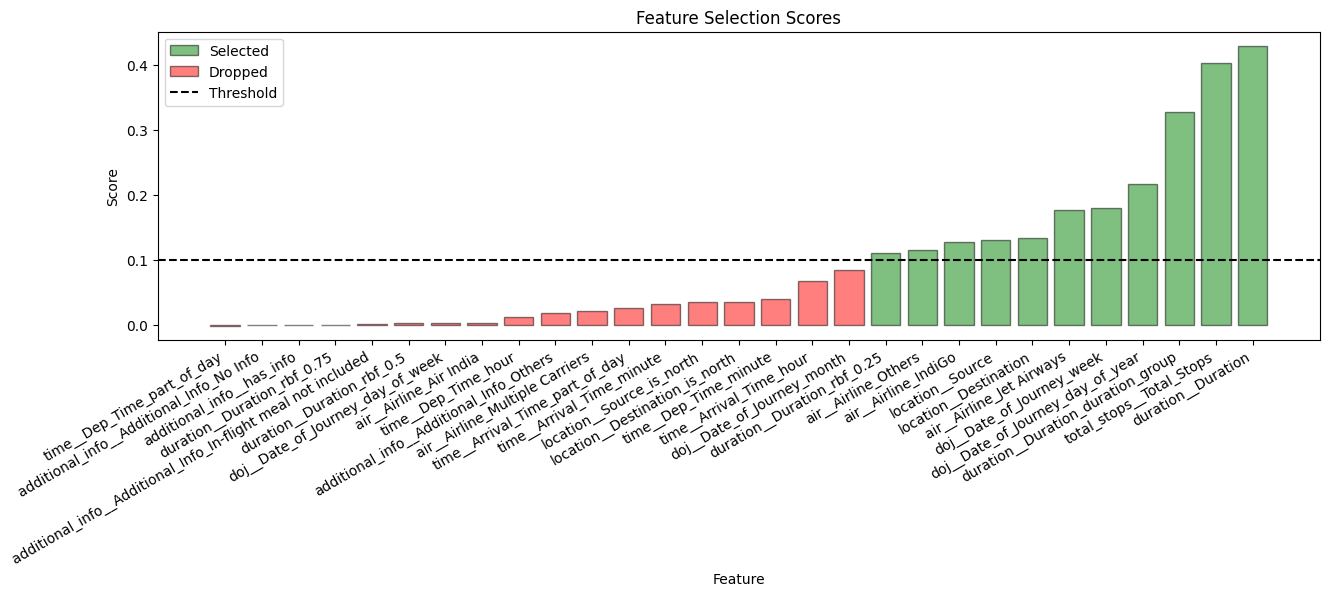

In [54]:
import matplotlib.pyplot as plt
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering.
- The Feature Selection algorithm selected 13 features out of that

